# Plot timelapse experiments

In [50]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter


nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

timeInterval=5 # the interval in minutes between timepoints

pd.set_option('display.max_columns', None)

In [52]:
# on server
base_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/'
df_paths = pd.DataFrame.from_dict({'data_path': [base_path+'/DPY27/1268/20241010_tl/',
                                                base_path+'/SDC1/1273/20241010_tl/']})

output_path=base_path+'/timelapse/'

if not os.path.exists(output_path+"/plots"):
    os.makedirs(output_path+"/plots")

df=pd.DataFrame()
dist=pd.DataFrame()
file_list = pd.DataFrame()
for path in df_paths['data_path']:
    df_tmp=pd.read_csv(path+"nuclei_analysis_v001.csv")
    df = pd.concat([df,df_tmp])
    dist_tmp=pd.read_pickle(path+"dist_analysis_v001.pkl")
    dist = pd.concat([dist,dist_tmp])
    file_list_tmp = pd.read_csv(path+"fileList.csv")
    file_list = pd.concat([file_list,file_list_tmp])

df.head()


,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,median,std,sum,variance,max,min,volume,id,timepoint,zproj_spots,zproj_nuclei,filename,date,experiment,strain,protein,raw_filepath,denoised_filepath
0,1,7,94,86,2.595147,636.169992,693.925964,92.824887,0.872761,107.571959,107.0,6.484235,3391206,42.045298,136,84,31525,DPY27_tl_20241010_1268_E_early_3h_5min_5um,1,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
1,1,12,109,105,12.474020,496.429384,694.701003,101.528729,0.830031,107.529925,107.0,6.489472,6841699,42.113248,133,85,63626,DPY27_tl_20241010_1268_E_early_3h_5min_5um,2,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
2,2,12,79,86,11.454992,719.387144,850.006206,90.298296,0.924498,106.020521,106.0,6.155991,5347251,37.896220,131,83,50436,DPY27_tl_20241010_1268_E_early_3h_5min_5um,2,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
3,3,4,92,78,15.633955,713.228358,532.298057,91.633967,0.873681,107.080584,107.0,6.356482,1878943,40.404859,130,84,17547,DPY27_tl_20241010_1268_E_early_3h_5min_5um,2,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...
4,1,13,98,95,5.480531,732.856621,844.874120,103.079933,0.919313,107.605859,107.0,6.522628,8190958,42.544679,133,84,76120,DPY27_tl_20241010_1268_E_early_3h_5min_5um,3,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...


## Add some variables
Coefficient of variation is independent of the mean signal

In [ ]:
def coefficientOfVariation(std,mean):
    return std/mean


df['cv'] = coefficientOfVariation(df['std'],df['mean'])
df['time'] = df['timepoint']*timeInterval

anisotropy = [5,1,1]    
df['zx_ratio'] = (df['bb_dimZ']*anisotropy[0])/(df['bb_dimX']*anisotropy[2])
df['zy_ratio'] = (df['bb_dimZ']*anisotropy[0])/(df['bb_dimY']*anisotropy[1])
df['xy_ratio'] = (df['bb_dimX']*anisotropy[2])/(df['bb_dimY']*anisotropy[1])




df.head()

# filter_indeces = (df['centroid_z']>=15) & (df['solidity']>=0.85) & (df['solidity']<=1) & (df['xy_ratio']>0.5) & (df['xy_ratio']<1.5) & (df['zx_ratio']>0.4) & (df['zx_ratio']<1.5) & (df['zy_ratio']>0.4) & (df['zy_ratio']<1.5) & (df['filename'].str.contains('dead') == False) 

filter_indeces =  (df['solidity']>=0.85) & (df['solidity']<=1) & (df['xy_ratio']>0.5) & (df['xy_ratio']<1.5) & (df['zx_ratio']>0.4) & (df['zx_ratio']<1.5) & (df['zy_ratio']>0.4) & (df['zy_ratio']<1.5) & (df['filename'].str.contains('dead') == False) 
filt=df[filter_indeces]
filt=filt.reset_index(drop=True)
filt.head()
df=filt

,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,median,std,sum,variance,max,min,volume,id,timepoint,zproj_spots,zproj_nuclei,filename,date,experiment,strain,protein,raw_filepath,denoised_filepath,cv,time,zx_ratio,zy_ratio,xy_ratio
0,2,12,79,86,11.454992,719.387144,850.006206,90.298296,0.924498,106.020521,106.0,6.155991,5347251,37.896220,131,83,50436,DPY27_tl_20241010_1268_E_early_3h_5min_5um,2,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,0.058064,10,0.697674,0.759494,1.088608
1,1,13,98,95,5.480531,732.856621,844.874120,103.079933,0.919313,107.605859,107.0,6.522628,8190958,42.544679,133,84,76120,DPY27_tl_20241010_1268_E_early_3h_5min_5um,3,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,0.060616,15,0.684211,0.663265,0.969388
2,1,12,92,88,5.196061,476.101581,554.505555,96.386348,0.934430,107.921613,108.0,6.588358,6974758,43.406463,133,84,64628,DPY27_tl_20241010_1268_E_early_3h_5min_5um,4,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,0.061048,20,0.681818,0.652174,0.956522
3,2,11,94,81,4.505424,637.416250,609.978955,100.339667,0.914683,107.359697,107.0,6.432998,5759633,41.383461,134,84,53648,DPY27_tl_20241010_1268_E_early_3h_5min_5um,4,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,0.059920,20,0.679012,0.585106,0.861702
4,1,13,97,94,5.061827,510.986256,558.734716,100.142053,0.890096,109.482319,109.0,6.947506,7272582,48.267843,137,84,66427,DPY27_tl_20241010_1268_E_early_3h_5min_5um,5,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,20241010_1268_E_early_3h_5min_5um,20241010,tl,1268,DPY27,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,/mnt/external.data/MeisterLab/Dario/Imaging/DP...,0.063458,25,0.691489,0.670103,0.969072


# Plot by experiment id

### Violin plots of timecourse

In [48]:
def colorize(im, color, clip_percentile=0.1):
    """
    Helper function to create an RGB image from a single-channel image using a 
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color



def get_first_timepoint_images(file_list,id,timeInterval=1,ax=None, first=True):
    if ax is None:
        ax = plt.gca()
    img_path=file_list[file_list["id"]==id].raw_filepath.iloc[0]
    if os.path.exists(img_path.replace('.nd2', '_max.tif')):
        img_path=img_path.replace('.nd2', '_max.tif')
        img_5d = BioImage(img_path, reader=bioio_tifffile.Reader)
        toProject=False
    else:
        img_path=file_list.denoised_filepath.iloc[index]
        img_5d = BioImage(img_path, reader=bioio_tifffile.Reader)
        toProject=True

    tdims=img_5d.dims.T
    if first:
        timepoints=range(0,4)
    else:
        timepoints=range(tdims-4,tdims)
    for i,t in enumerate(timepoints):
        if(toProject):
            img = img_5d.get_image_data("ZXYC",T=t)
            img = np.max(img,axis=0)
        else:
            img = img_5d.get_image_data("XYC",T=t,Z=0)

        im_red = colorize(img[:,:, 0], (1, 0, 1))
        im_green = colorize(img[:,:, 1], (0, 1, 0))

        #im_composite = np.clip(im_red + im_green, 0, 1) # both channels
        im_composite = np.clip(im_red, 0, 1) # nuclear channel only

        ax[i].axis(False)
        ax[i].imshow(im_composite)
        ax[i].text(0,0,'t='+str(t*timeInterval),fontsize=12)
    return ax 

def plot_violin(df,file_list,timeInterval,output_path, metric='sum'):
    ids = df.id.unique()
    for i in ids:
        df_subset = df[df['id'] == i]

        fig = plt.figure(figsize=(12,10),dpi=200)
        subfigs = fig.subfigures(2,1)

        axs_violin = subfigs[0].subplots(1,1,sharex=False, sharey=False)
        pointOrder=[t*timeInterval for t in range(df_subset.timepoint.max()+1)] # necessary to deal with early timepoints where no nuclei are detected
        sns.violinplot(data=df_subset, y=metric, x="time",color="skyblue", inner=None,order=pointOrder, ax=axs_violin)
        for tick in axs_violin.get_xticklabels():
            tick.set_rotation(45)
        axs_violin.set_xlabel("Time (min)")
        axs_violin.set_ylabel(metric+" of intensity of mSG::"+df_subset.protein.iloc[0])

        # calculate median from first 4 timepoints for horizontal line
        t0_median = df_subset[df_subset['timepoint'] <= 4][metric].median()
        axs_violin.axhline(y=t0_median, color='grey', linestyle='--', linewidth=0.5)

        # get medians points
        medians_df = df_subset.groupby(['timepoint','time'])[metric].median().reset_index(name='Median')
        axs_violin.scatter(x=medians_df.timepoint, y=medians_df.Median, color='black', s=10)

        # get number of nuclei at each timepoint
        num_nuclei = df_subset.groupby(['timepoint','time'])[metric].count().reset_index(name='num_nuclei')
        ylims = plt.gca().get_ylim()
        ypos=ylims[0]+0.01*np.abs(ylims[0])
        for n in range(len(num_nuclei)):
            axs_violin.text(x=num_nuclei.timepoint.iloc[n], y=ypos, s=num_nuclei.num_nuclei.iloc[n], color='blue', fontsize=8, ha='center')

        axs_violin.set_title(i+'::mSG signal timelapse') 

        # add plot of first timepoints
        axs_timepoints = subfigs[1].subplots(2,4)
        get_first_timepoint_images(file_list,i,timeInterval,axs_timepoints[0,:], first=True)
        get_first_timepoint_images(file_list,i,timeInterval,axs_timepoints[1,:], first=False)
        plt.savefig(output_path+"/plots/"+i+"_"+metric+".png")
        plt.close()

In [49]:
plot_violin(df,file_list,timeInterval,output_path, metric='cv')

plot_violin(df,file_list,timeInterval,output_path, metric='sum')

## Plot vs numNuclei

<Axes: xlabel='numNuclei', ylabel='mean_cv'>

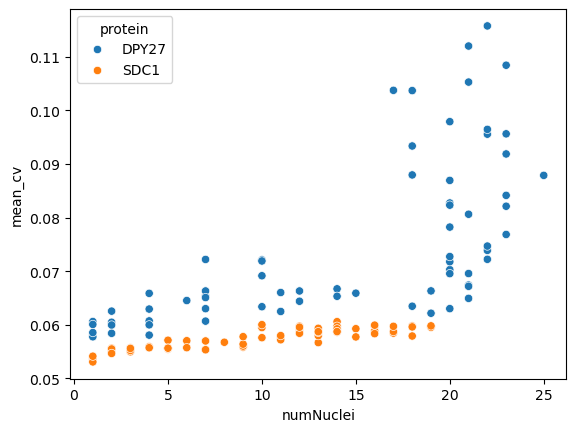

In [23]:
# Group by 'id' and 'time', then aggregate
result = df.groupby(['protein','id', 'time']).agg(
    numNuclei=('cv', 'size'),
    mean_cv=('cv', 'mean'),
    std_cv=('cv', 'std')
).reset_index()

#print(result)
sns.scatterplot(data=result, x='numNuclei', y='mean_cv', hue='protein')

## Plot with different y scales

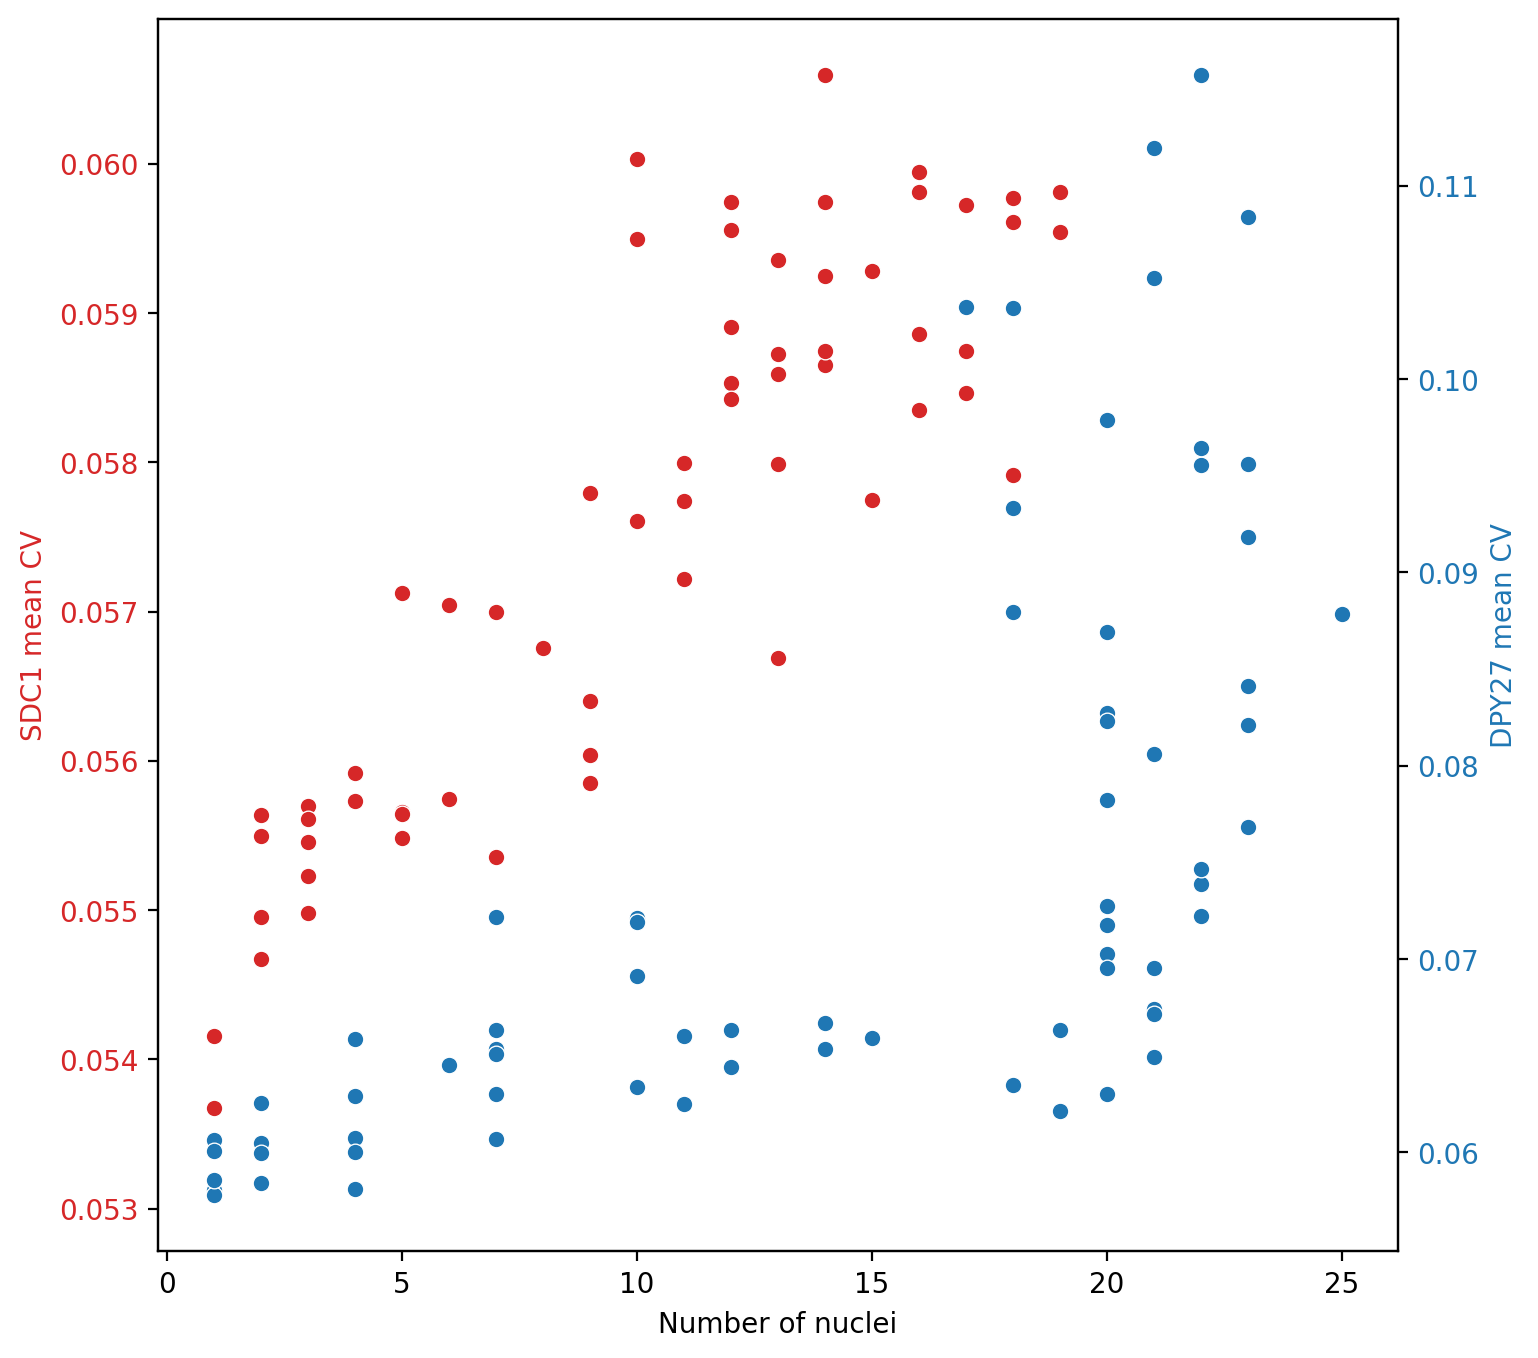

In [25]:
fig, ax1 = plt.subplots(figsize=(8,8),dpi=200)
color = 'tab:red'
ax1.set_xlabel('Number of nuclei')
ax1.set_ylabel('SDC1 mean CV', color=color)
sns.scatterplot(data=result[result.protein=="SDC1"], x='numNuclei', y='mean_cv', color=color, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('DPY27 mean CV', color=color)
sns.scatterplot(data=result[result.protein=="DPY27"], x='numNuclei', y='mean_cv', color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()
#sns.scatterplot(data=result, x='numNuclei', y='mean_cv', hue='protein')